In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

from mie2c.e2c import E2C, compute_loss
from mie2c.ball_model import (get_ball_encoder, get_ball_decoder,
    get_ball_transition, get_ball_linear_transition, get_ball_pwa_transition)

### Method to create (3,32,32) tensor

In [3]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [4]:
def step(x0, Ak, add_noise=False):
    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [5]:
n = 4 
dh = 0.05

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32

# Training data
NUM_DATA = 500

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

# Test data
NUM_TEST = 100

X_test = np.zeros((NUM_TEST,3,W,W))
X_next_test = np.zeros((NUM_TEST,3,W,W))

count = 0
while count < NUM_TEST:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X_test[count,:,:,:] = img
    X_next_test[count,:,:,:] = img_new

    count += 1

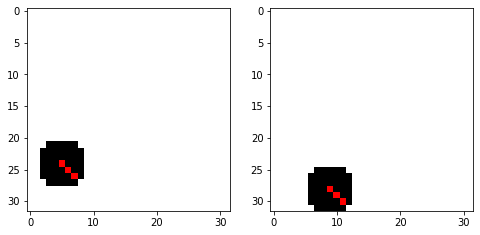

In [6]:
idx = 0
img, img_next = X[idx], X_next[idx]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_next.transpose(1,2,0))

### Construct encoder/decoder

In [7]:
dim_in = X[0].shape
dim_z = 6
dim_u = 0

encoder = get_ball_encoder(dim_in, dim_z)

# transition = get_ball_transition(dim_z, dim_u)
transition = get_ball_linear_transition(dim_z, dim_u, low_rank=True)
# transition = get_ball_pwa_transition(1, dim_z, dim_u)

decoder = get_ball_decoder(dim_z, dim_in) 

gpu = 1
model = E2C(encoder, transition, decoder)
# model.to(gpu);

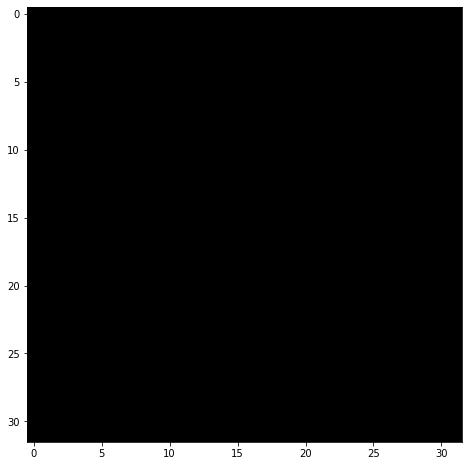

In [8]:
inp = torch.from_numpy(X[:2]).float() # .to(gpu)
mean, logvar = model.encode(inp)
x_dec = model.decode(mean)[0]

fig = plt.figure(figsize=(8,8))
plt.imshow(x_dec.detach().cpu().numpy().transpose(1,2,0))

## Training loop

In [9]:
# training parameters
# note: not sure how many epochs are actually needed but loss should go to ~150
TRAINING_ITERATIONS = int(10000)
BATCH_SIZE = int(32)
CHECKPOINT_AFTER = int(500)
SAVEPOINT_AFTER = int(1000)
TEST_BATCH_SIZE = int(32)
KL_LAMBDA = .25

rand_idx = list(np.arange(0, X_next.shape[0]-1))
indices = [rand_idx[ii * BATCH_SIZE:(ii + 1) * BATCH_SIZE] \
    for ii in range((len(rand_idx) + BATCH_SIZE - 1)     // BATCH_SIZE)]
if len(indices[-1]) == 1:
    # make sure batch doesn't just have one data point
    indices[-1].append(indices[-1][0])

dataset = torch.utils.data.TensorDataset(torch.tensor(X).float(), \
                                         torch.tensor(X_next).float())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = optim.Adam(model.parameters())

In [10]:
itr = 0
for epoch in range(TRAINING_ITERATIONS):
    iter_count = 0
    for x, x_next in dataloader:
        optimizer.zero_grad()
        action = torch.empty(NUM_DATA, dim_u)

        model(x, action, x_next)
        elbo_loss, kl_loss = compute_loss(model.x_dec, model.x_next_dec, model.x_next_pred_dec,
                                          x, x_next,
                                          model.Qz, model.Qz_next, model.Qz_next_pred)
        loss = elbo_loss + KL_LAMBDA * kl_loss

        if itr % 500 == 0:
            print(loss.item())

        loss.backward()
        optimizer.step()
        iter_count += 1
        itr += 1

2982.6908652120555
170.27755329016594
158.72257253730388
154.78136198670478
151.26445316350674
141.32197870749235
129.46685858320578
127.92978880008448
118.13563681124315
116.33412953183311
109.65481765178632
107.66975708685868
81.72633988970297
74.30915891763804
63.68219507612005
52.27229393391663
51.15312999068459
50.69786189750354
37.69595864081071
42.84960683767285
37.73085421184449
32.91771014367669
35.88301314828988
34.451043137614995
30.248187097459876
42.990227287478184


KeyboardInterrupt: 

In [11]:
x_pred = model.predict(torch.tensor(X).float(), torch.zeros(NUM_DATA,1).float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


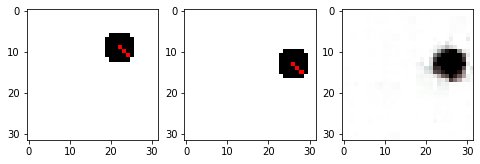

In [30]:
idx = np.random.choice(NUM_DATA)
img, img_next, img_next_pred = X[idx], X_next[idx], x_pred[idx].detach().numpy()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,3,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,3,2)
plt.imshow(img_next.transpose(1,2,0))

fig.add_subplot(1,3,3)
plt.imshow(img_next_pred.transpose(1,2,0))

In [31]:
x_pred = model.predict(torch.tensor(X_test).float(), torch.zeros(NUM_TEST,1).float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


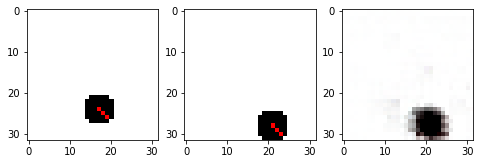

In [48]:
idx = np.random.choice(NUM_TEST)
img, img_next, img_next_pred = X_test[idx], X_next_test[idx], x_pred[idx].detach().numpy()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,3,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,3,2)
plt.imshow(img_next.transpose(1,2,0))

fig.add_subplot(1,3,3)
plt.imshow(img_next_pred.transpose(1,2,0))